In [46]:
import seaborn as sns
import scipy.stats as stats
from scipy import stats
from math import sqrt
import scipy
import numpy as np 
import datetime
import pandas as pd 
import sklearn
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import pickle
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

# Step 2: Explorator Data Analysis

Become familiar with the data. Look to see if there are any extreme values.

Additionally create data visualizations to determine if there are any relationships between your features and your target variables.


In [37]:
#reading data in
kc_df = pd.read_csv('kc_house_data_train.csv')
kc_house_test = pd.read_csv('kc_house_data_test_features.csv')

Text(0, 0.5, 'price')

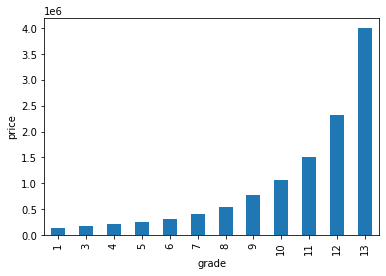

In [72]:
#a understanding of price (mean) vs grade
kc_df.groupby('grade')['price'].mean().plot(kind='bar')
plt.ylabel('price')

C:\Users\GMoneyMan\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


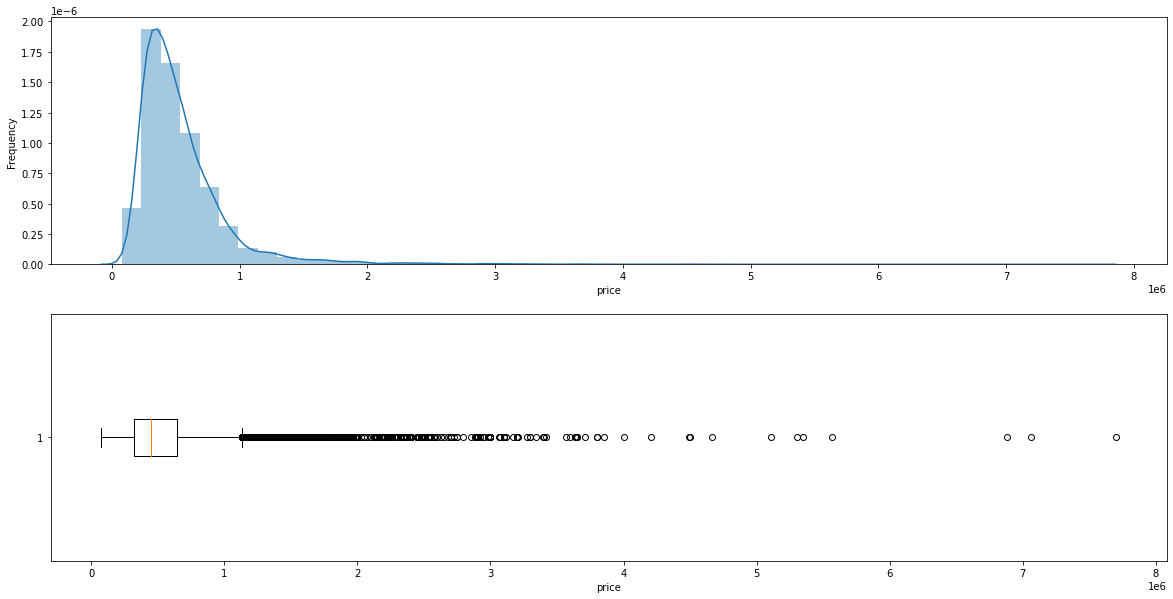

In [41]:
#a graph to understand where all of the price points are located and where the outliers are
fig = plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.ylabel('Frequency')
sns.distplot(kc_df['price'])
plt.subplot(2,1,2)
plt.boxplot(kc_df['price'], vert= False)
plt.xlabel('price')
plt.show()

Text(0, 0.5, 'Number of Bedrooms')

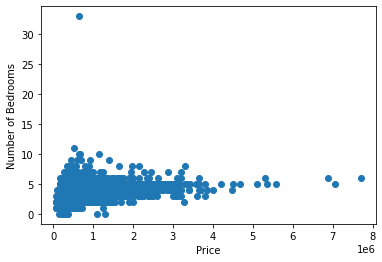

In [44]:
#a plot to see the distribution of bedrooms vs how expensive a house is (and see outliers)
plt.scatter(kc_df['price'], kc_df['bedrooms'])
plt.xlabel("Price")
plt.ylabel("Number of Bedrooms")

In [70]:
# creating a 'heat map' that color codes the correlation between variables and price
price_corr = kc_df[kc_df.columns[:]].corr()['price'][:]
price_corr.sort_values()
price_coef = pd.DataFrame(price_corr)
ax = sns.heatmap(price_coef)

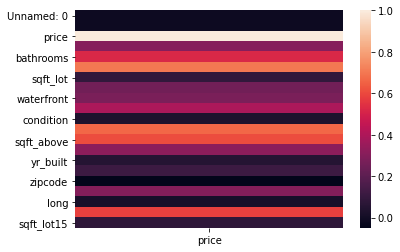

### Statistical test 1

Do houses that have 3 bathroom cost the same as houses that have 4 bathrooms?

In [122]:
bath_3 = kc_df.groupby('bathrooms')['price'].value_counts()[3.00]
bath_4 = kc_df.groupby('bathrooms')['price'].value_counts()[4.00]
stats.ttest_ind(bath_3, bath_4)

Ttest_indResult(statistic=3.978064641027799, pvalue=7.988144512575149e-05)

The p-value is lower than 0.025 and is therefore statistically significant and we can reject the null hypothesis

### Statistical test 2

Do houses that have view of 2 have the same price as houses that have a views 3?

In [112]:
v_2 = kc_df.groupby('view')['price'].value_counts()[3]
v_3 = kc_df.groupby('view')['price'].value_counts()[4]

stats.ttest_ind(v_2, v_3)

Ttest_indResult(statistic=1.2675515851125514, pvalue=0.2055388356595398)

The p-value is greater than our alpha and as such we fail to reject the null hypothesis 

### Statistical test 3

The average mean price of houses with waterfront is the same as houses without waterfront

In [87]:
kc_df.groupby('waterfront')['price'].mean()

waterfront
0    5.315051e+05
1    1.688486e+06
Name: price, dtype: float64

In [99]:
no_wf = kc_df.groupby('waterfront')['price'].value_counts()[0]
wf = kc_df.groupby('waterfront')['price'].value_counts()[1]

In [100]:
stats.ttest_ind(wf, no_wf)

Ttest_indResult(statistic=-3.2246793813636536, pvalue=0.0012723732636321676)

The p-value is lower than 0.025 and is therefore statistically significant and we can reject the null hypothesis

In [3]:
#dropping the values we don't want to bother us since we know from 
#earlier tests they are not good
kc_df.drop(['id', 'lat', 'long', 'Unnamed: 0', 'date', 'view', 'sqft_living15', 'sqft_lot15' ], axis = 1, inplace = True)

l_price = kc_df['price']

## Setting up functions and cleaning

In [4]:
#creating a floor and ceiling for bedroom extreme values, and applying through df
def n_bed(row):
    if row['bedrooms'] ==0:
        row['bedrooms'] = row['floors']
    if row['bedrooms'] > 10:
        row['bedrooms'] = 10
    return row

kc_df = kc_df.apply(n_bed, axis = 1)

In [5]:
#creating a floor for bathroom extreme values, and applying through df
def n_bath(row):
    if row['bathrooms'] < 1:
        row['bathrooms'] = 1
    return row

kc_df = kc_df.apply(n_bath, axis = 1)

In [6]:
#during sqft_basement into a categorical binary
kc_df['sqft_basement'] = np.where(kc_df['sqft_basement'] != 0, 1, 0)

In [7]:
#creates a column and fills it with number of years since it has been renovated
kc_df['yr_renovate'] = np.nan

def yr_renov(row):
    if row['yr_renovated'] == 0:
        row['yr_renovate'] = 0
    if row['yr_renovated'] != 0:
        row['yr_renovate'] = 2021 - row['yr_built']
    return row 

kc_df = kc_df.apply(yr_renov, axis = 1)

In [8]:
#creates a column and fills it with length since year built, or renovated if not available, 
#then drops yr_built and yr_renovated
kc_df['yr_updated'] = np.nan

def yr_update(row):
    if row['yr_renovated'] == 0:
        row['yr_updated'] =2021 - row['yr_built']
    elif row['yr_renovated'] != 0:
        row['yr_updated'] = 2021 - row['yr_renovated']
    return row['yr_updated']

kc_df['yr_updated'] = kc_df.apply(yr_update, axis = 1)
kc_df.drop(['yr_built',	'yr_renovated' ], axis = 1, inplace = True)

In [9]:
#creates a column showing the ratio between living and lot sqft, and fills it
kc_df['sqft_liv_lot'] = np.nan

def n_sqft_liv_lot(row):
    row['sqft_liv_lot'] = (row['sqft_living'] / row['sqft_lot'])    
    return row

kc_df = kc_df.apply(n_sqft_liv_lot, axis = 1)

In [ ]:
#Did not run, it didn't help my error enough
def city_distance(row):
    dist = geopy.distance.geodesic((47.6205,122.3493), (row['lat'], abs(row['long'])))
    return dist.miles

kc_df['dist_city'] = kc_df.apply(city_distance, axis=1)

## Setting up Dummies

In [11]:
#creating categorical variables (for dummies) and continuous variables (for polynomials)
cat_var = ['zipcode', 'grade', 'waterfront']
cont_var = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_above', 'sqft_lot', 'sqft_liv_lot', 'yr_updated', 'yr_renovate']

In [12]:
#function to create dummy variables for the specific categorical variables 
def to_dummies(df, features):
        dum_df = []
    for f in features:
        dum_df.append(pd.get_dummies(df[f], prefix='{}'.format(str(f)[:3]), drop_first=True))
    df = df.drop(features, axis = 1)
    df = pd.concat([df] + dum_df ,axis=1)
    return df

In [13]:
#turning the categorical variables into dummies on the dataframe
kc_df = to_dummies(kc_df, cat_var)

In [28]:
#creating a list of the columns, including dummies, but excluding price
summary_features = list(kc_df.columns.drop('price'))

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'condition',
 'sqft_above',
 'sqft_basement',
 'yr_renovate',
 'yr_updated',
 'sqft_liv_lot',
 'zip_98002.0',
 'zip_98003.0',
 'zip_98004.0',
 'zip_98005.0',
 'zip_98006.0',
 'zip_98007.0',
 'zip_98008.0',
 'zip_98010.0',
 'zip_98011.0',
 'zip_98014.0',
 'zip_98019.0',
 'zip_98022.0',
 'zip_98023.0',
 'zip_98024.0',
 'zip_98027.0',
 'zip_98028.0',
 'zip_98029.0',
 'zip_98030.0',
 'zip_98031.0',
 'zip_98032.0',
 'zip_98033.0',
 'zip_98034.0',
 'zip_98038.0',
 'zip_98039.0',
 'zip_98040.0',
 'zip_98042.0',
 'zip_98045.0',
 'zip_98052.0',
 'zip_98053.0',
 'zip_98055.0',
 'zip_98056.0',
 'zip_98058.0',
 'zip_98059.0',
 'zip_98065.0',
 'zip_98070.0',
 'zip_98072.0',
 'zip_98074.0',
 'zip_98075.0',
 'zip_98077.0',
 'zip_98092.0',
 'zip_98102.0',
 'zip_98103.0',
 'zip_98105.0',
 'zip_98106.0',
 'zip_98107.0',
 'zip_98108.0',
 'zip_98109.0',
 'zip_98112.0',
 'zip_98115.0',
 'zip_98116.0',
 'zip_98117.0',
 'zip_98118.0',
 'zip_

In [27]:
summary_features

In [30]:
best_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'sqft_above', 'sqft_basement', 'yr_renovate', 'yr_updated',
       'sqft_liv_lot', 'zip_98004.0', 'zip_98005.0', 'zip_98006.0',
       'zip_98007.0', 'zip_98008.0', 'zip_98010.0', 'zip_98011.0',
       'zip_98014.0', 'zip_98019.0', 'zip_98023.0', 'zip_98024.0',
       'zip_98027.0', 'zip_98028.0', 'zip_98029.0', 'zip_98033.0',
       'zip_98034.0', 'zip_98038.0', 'zip_98039.0', 'zip_98040.0',
       'zip_98045.0', 'zip_98052.0', 'zip_98053.0', 'zip_98055.0',
       'zip_98056.0', 'zip_98058.0', 'zip_98059.0', 'zip_98065.0',
       'zip_98072.0', 'zip_98074.0', 'zip_98075.0', 'zip_98077.0',
       'zip_98092.0', 'zip_98102.0', 'zip_98103.0', 'zip_98105.0',
       'zip_98106.0', 'zip_98107.0', 'zip_98108.0', 'zip_98109.0',
       'zip_98112.0', 'zip_98115.0', 'zip_98116.0', 'zip_98117.0',
       'zip_98118.0', 'zip_98119.0', 'zip_98122.0', 'zip_98125.0',
       'zip_98126.0', 'zip_98133.0', 'zip_98136.0', 'zip_98144.0',
       'zip_98146.0', 'zip_98148.0', 'zip_98155.0', 'zip_98166.0',
       'zip_98168.0', 'zip_98177.0', 'zip_98178.0', 'zip_98188.0',
       'zip_98198.0', 'zip_98199.0', 'gra_5.0', 'gra_6.0', 'gra_7.0',
       'gra_8.0', 'gra_9.0', 'gra_10.0', 'gra_11.0', 'gra_12.0', 'gra_13.0',
       'wat_1.0']

## Creating a polynomial feature

In [ ]:
#setting up the type of polynomial
poly = PolynomialFeatures(degree = 2, include_bias = False)

In [ ]:
#transforming our data into polynomial 
poly_data = poly.fit_transform(kc_df[cont_var])

In [ ]:
#grabbing the names of the newly made columns
poly_columns = poly.get_feature_names(kc_df[cont_var].columns)

In [ ]:
#creating a data frame of those features
df_poly = pd.DataFrame(poly_data, columns = poly_columns) 

In [ ]:
#adding them to the other data frame
kc_df_poly2 = pd.merge(df_poly, kc_df, left_index=True, right_index=True)

In [ ]:
#putting all of the columbs except price into a list
summary_features1 = list(kc_df_poly2.columns.drop('price'))

## Testing our results

In [19]:
#testing the dataframe against the features     
    df_features = kc_df[summary_features]
    X_train, X_test, y_train, y_test = train_test_split(df_features, l_price, random_state=34,test_size=0.2)
    #instanciate a linear regression object
    lm = linear_model.LinearRegression()
    #fit the linear regression to the data
    lm = lm.fit(X_train, y_train)
    y_train_pred = lm.predict(X_train)
    #using models to train the data
    train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
    train_mse = metrics.mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    # Test Set
    y_pred = lm.predict(X_test)
    #test_mae = metrics.mean_absolute_error(y_test, y_pred)
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    #print('Mean Absolute Error:' + str(metrics.mean_absolute_error(y_test, y_pred)))
    #print('Mean Squared Error:' + str(metrics.mean_squared_error(y_test, y_pred)))
    print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Training:  154553 vs. Testing:  160349


In [34]:
#fits the scaler to linear regression
def scale_fit_pickle_origin(df_features, target):
    """
    Scaling df with features,
    Fit linear model with scaled features
    Create pickle file with Scaler and Model
    params: 
            df_features - most important features 
            target - Series
    """
#     scaler = StandardScaler()
#     # fit the scaler to the training data
#     scaler.fit(df_features)
#     #transform the training data
#     scaled_data = scaler.transform(df_features)
#     #create dataframe
#     df_features_scaled = pd.DataFrame(data=scaled_data, columns=df_features.columns, index=df_features.index)
    lm_final = LinearRegression()
#     #fit the linear regression to the data
    lm_final = lm_final.fit(df_features, target)
    pickle_out = open("model.pickle","wb")
    pickle.dump(lm_final, pickle_out)
    pickle_out.close()
#     pickle_out = open('scaler.pickle', "wb")
#     pickle.dump(scaler, pickle_out)
#     pickle_out.close()
    return print('pickle created')

In [35]:
scale_fit_pickle_origin(kc_df[best_features], kc_df['price'])

pickle created


## F-Test

In [25]:
#creating a recursive function that selects the best features
def RFECV_selection(df, y):
    from sklearn.feature_selection import RFECV
    X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=9, test_size=0.2)
    scaler = StandardScaler()
    # fit the scaler to the training data
    scaler.fit(X_train)
    #transform the training data
    scaled_data = scaler.transform(X_train)
    X_train_scaled = pd.DataFrame(data=scaled_data, columns=df.columns, index=X_train.index)
    #transform the test data
    scaled_test_data = scaler.transform(X_test)
    #create dataframe
    X_test_scaled = pd.DataFrame(data=scaled_test_data, columns=df.columns, index=X_test.index)
    ols = LinearRegression()
    # Create recursive feature eliminator that scores features by mean squared errors
    selector = RFECV(estimator=ols, step=2, cv=7,  scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
    # Fit recursive feature eliminator 
    selector.fit(X_train_scaled, y_train)
    selected_rfe = X_train_scaled.columns[selector.support_]
    removed_rfe = X_train_scaled.columns[~selector.support_]
    #instantiate a linear regression object
    lm_rfe = LinearRegression()
    #fit the linear regression to the data
    lm_rfe = lm_rfe.fit(X_train_scaled[selected_rfe], y_train)
    y_rfe = lm_rfe.predict(X_train_scaled[selected_rfe])
    trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))
    print('Training Root Mean Squared Error:' , trainRFE_rmse)
    y_pred_rfe = lm_rfe.predict(X_test_scaled[selected_rfe])
    testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))
    print('Testing Root Mean Squared Error:' , testRFE_rmse)
    print('Most Importand features acoring to RFECV :')
    return selected_rfe

In [29]:

RFECV_selection(kc_df[summary_features], kc_df['price'])

Fitting estimator with 92 features.
Fitting estimator with 90 features.
Fitting estimator with 88 features.
Fitting estimator with 86 features.
Fitting estimator with 84 features.
Training Root Mean Squared Error: 156684.55151870442
Testing Root Mean Squared Error: 151374.3581014157
Most Importand features acoring to RFECV :


Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'sqft_above', 'sqft_basement', 'yr_renovate', 'yr_updated',
       'sqft_liv_lot', 'zip_98004.0', 'zip_98005.0', 'zip_98006.0',
       'zip_98007.0', 'zip_98008.0', 'zip_98010.0', 'zip_98011.0',
       'zip_98014.0', 'zip_98019.0', 'zip_98023.0', 'zip_98024.0',
       'zip_98027.0', 'zip_98028.0', 'zip_98029.0', 'zip_98033.0',
       'zip_98034.0', 'zip_98038.0', 'zip_98039.0', 'zip_98040.0',
       'zip_98045.0', 'zip_98052.0', 'zip_98053.0', 'zip_98055.0',
       'zip_98056.0', 'zip_98058.0', 'zip_98059.0', 'zip_98065.0',
       'zip_98072.0', 'zip_98074.0', 'zip_98075.0', 'zip_98077.0',
       'zip_98092.0', 'zip_98102.0', 'zip_98103.0', 'zip_98105.0',
       'zip_98106.0', 'zip_98107.0', 'zip_98108.0', 'zip_98109.0',
       'zip_98112.0', 'zip_98115.0', 'zip_98116.0', 'zip_98117.0',
       'zip_98118.0', 'zip_98119.0', 'zip_98122.0', 'zip_98125.0',
       'zip_98126.0', 'zip_98133.0', 'zip_9813

In [ ]:
# f_test selection where k is the number of features you want returned
def f_test_selection(df, target, k):
    X_train, X_test, y_train, y_test = train_test_split(df, target, random_state=9, test_size=0.2)
    scaler = StandardScaler()
    # fit the scaler to the training data
    scaler.fit(X_train)
    #transform the training data
    scaled_data = scaler.transform(X_train)
    X_train_scaled = pd.DataFrame(data=scaled_data, columns=df.columns, index=X_train.index)
    #transform the test data
    scaled_test_data = scaler.transform(X_test)
    #create dataframe
    X_test_scaled = pd.DataFrame(data=scaled_test_data, columns=df.columns, index=X_test.index)
    selector = SelectKBest(f_regression, k= k)
    selector.fit(X_train_scaled, y_train)
    selected_columns = X_train_scaled.columns[selector.get_support()]
    removed_columns = X_train_scaled.columns[~selector.get_support()]
    return selected_columns